In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import nltk
from nltk.util import bigrams
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
from adjustText import adjust_text

In [2]:
exclude_terms = {
    'desse', 'aí', 'n', 'https', '@', 'user', 'link', '#', '??', '!!', '_:', '.:', '!:', '? ?', '! !', '_ :', '! :', '? :', 'rt',
    'ta', 'tá', 'q', 'pq', 'ter', 'pra', 'vcs', 'todos', 'aí', 'nunca', 'fala', 'ver', 'coisa', 'desse', 'todo', 'quer', 'agora', 'faz',
    'n', 'fazer', 'ainda', 'dia', 'pode', 'tudo', 'nao', 'nada', 'vc', 'vai', 'pq', 'por que', 'porque', 'eh', 'ne', 'né', 'é', 'p',
    'la', 'lá', 'ai', 'aí', 'to', 'tô','sobre','fez','pois','onde','aqui','pro','dar','ficar','fica','d','[]'
}

In [4]:
def generate_word_graph(category, csv_file_name, exclude_terms=set(), num_top_words=50, node_color="lightblue"):
    # Define the path to the "datasets" folder relative to your current notebook's location.
    datasets_folder = "../datasets"

    # Construct the full path to the CSV file
    csv_file_path = os.path.join(datasets_folder, csv_file_name)

    # Check if the file exists before attempting to read it
    if os.path.isfile(csv_file_path):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)

        # Filter rows based on the category
        df_limpo = df[df[category] == 1]

        # Process and tokenize text data
        stop_words = set(stopwords.words("portuguese"))

        # Create a list of words
        all_words = []
        for text in df_limpo["text"]:
            tokens = word_tokenize(text)
            tokens = [word.lower() for word in tokens if word.isalpha()]  # Remove punctuation and convert to lowercase
            tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
            tokens = [word for word in tokens if word not in exclude_terms]  # Remove excluded terms
            all_words.extend(tokens)

        # Create a list of unique words
        unique_words = list(set(all_words))

        # Create a word-to-index mapping
        word_to_index = {word: i for i, word in enumerate(unique_words)}

        # Initialize a weight matrix
        num_words = len(unique_words)
        weight_matrix = np.zeros((num_words, num_words))

        # Fill the weight matrix based on co-occurrence
        window_size = 2
        for text in df_limpo["text"]:
            tokens = word_tokenize(text)
            tokens = [word.lower() for word in tokens if word.isalpha()]
            tokens = [word for word in tokens if word not in stop_words]
            tokens = [word for word in tokens if word not in exclude_terms]
            for i in range(len(tokens)):
                for j in range(i + 1, min(i + window_size + 1, len(tokens))):
                    word1 = tokens[i]
                    word2 = tokens[j]
                    if word1 in word_to_index and word2 in word_to_index:
                        index1 = word_to_index[word1]
                        index2 = word_to_index[word2]
                        weight_matrix[index1][index2] += 1
                        weight_matrix[index2][index1] += 1

        # Calculate the importance of each word based on the sum of weights
        word_importance = weight_matrix.sum(axis=1)

        # Select the top N most influential words
        top_words_indices = np.argsort(word_importance)[-num_top_words:]
        top_words = [unique_words[i] for i in top_words_indices]

        # Create a subgraph with only the top N words and their connections
        G = nx.Graph()
        for word in top_words:
            importance = word_importance[word_to_index[word]]
            # Rescale importance values to node sizes within a reasonable range
            node_size = 200 + 2000 * (importance - min(word_importance)) / (max(word_importance) - min(word_importance))
            G.add_node(word, importance=importance, size=node_size)

        for i in top_words_indices:
            for j in top_words_indices:
                if i != j:
                    weight = weight_matrix[i][j]
                    if weight > 0:
                        word1 = unique_words[i]
                        word2 = unique_words[j]
                        G.add_edge(word1, word2, weight=weight)

        # Draw the word graph with node sizes based on importance and thinner edges
        pos = nx.spring_layout(G, k=0.25)  # Adjust k for better layout
        node_sizes = [G.nodes[node]['size'] for node in G.nodes]
        # Reduce the edge widths by a scaling factor
        edge_widths = [0.05 * (0.1 + G[word1][word2]['weight']) for word1, word2 in G.edges()]
        labels = {word: word for word in G.nodes()}

        # Specify a more subtle bounding box for labels to avoid overlap
        bbox = dict(boxstyle="round,pad=0.3", alpha=0.8, edgecolor="none", facecolor="none")

        plt.figure(figsize=(12, 12))
        
        # Use the specified node color
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color)
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black", bbox=bbox)
        plt.axis("off")
        plt.title(f"{category} word graph")
        plt.show()

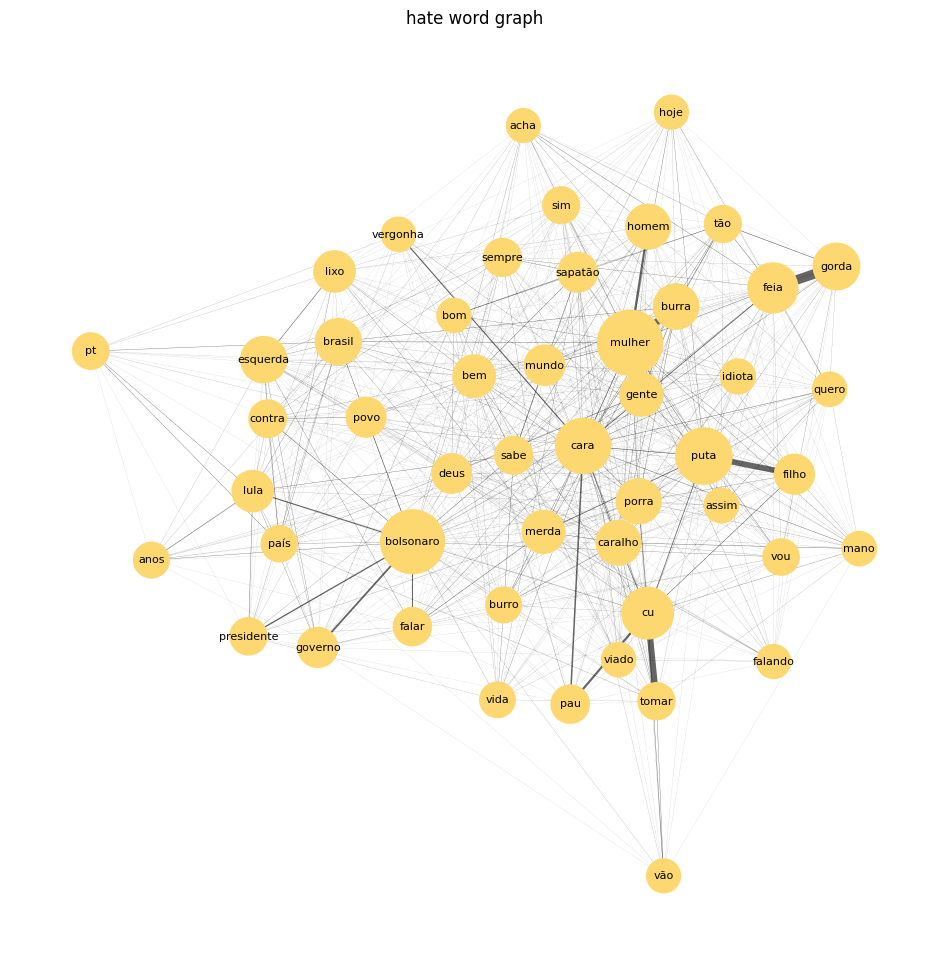

In [5]:
# Example usage:
generate_word_graph("hate", "tupi_hierarchy.csv", exclude_terms,50,"#FDD870")

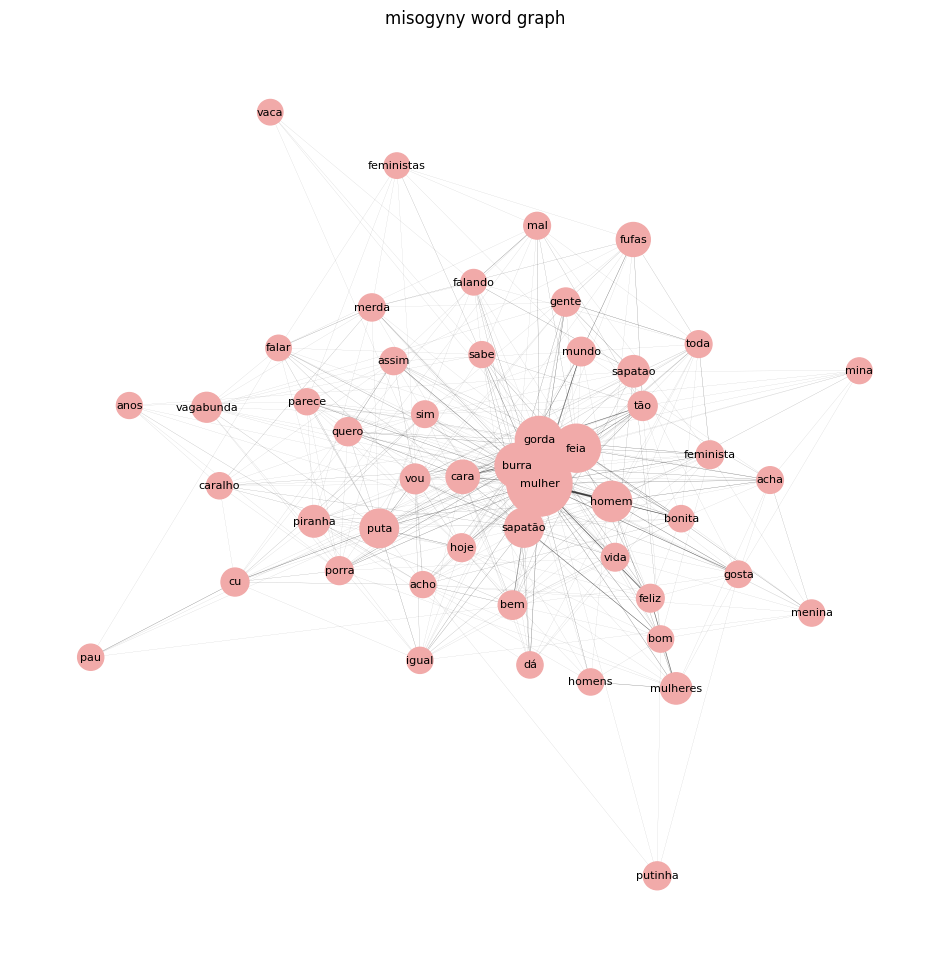

In [6]:
generate_word_graph("misogyny", "tupi_hierarchy.csv", exclude_terms,50,"#F1AAA9")

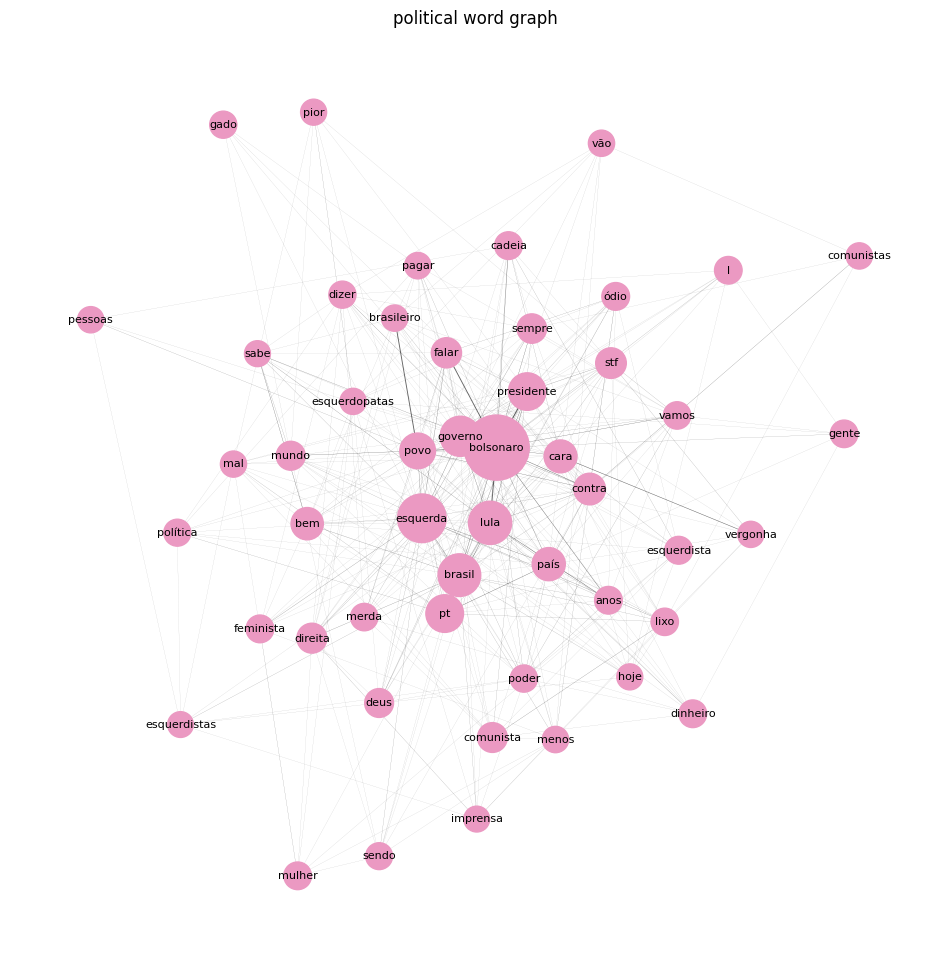

In [7]:
generate_word_graph("political", "tupi_hierarchy.csv", exclude_terms,50,"#EB99C2")

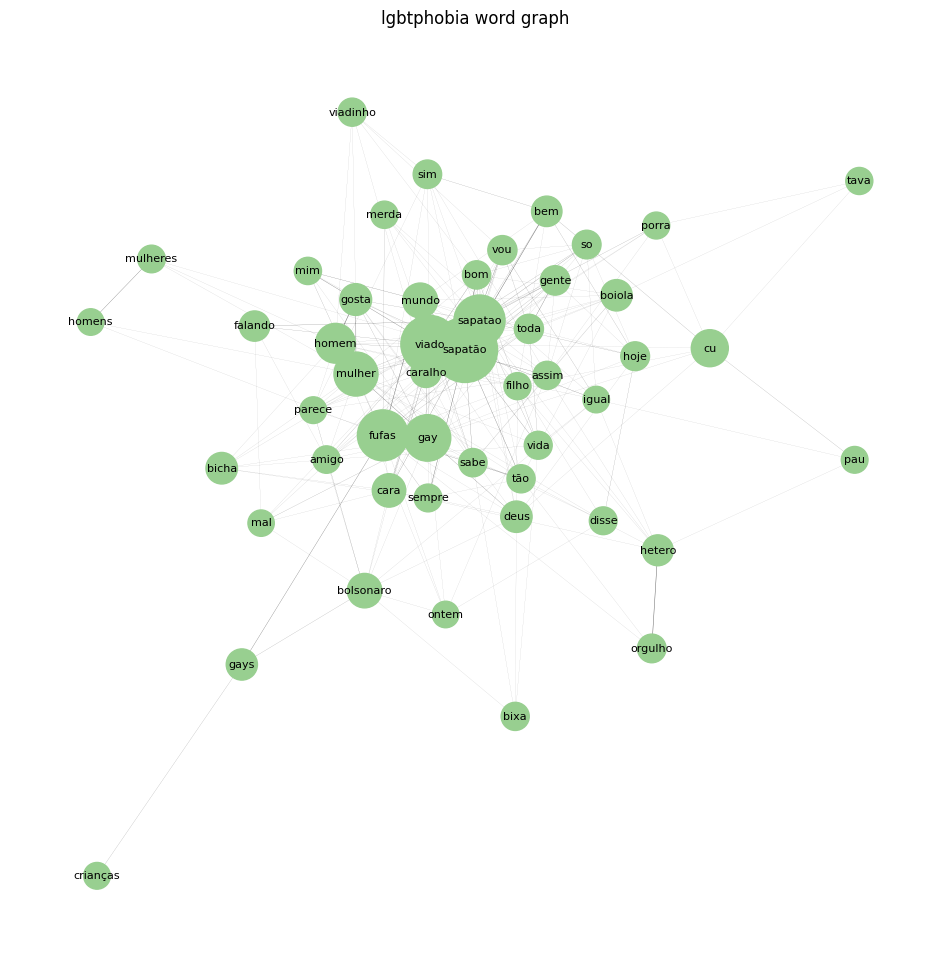

In [8]:
generate_word_graph("lgbtphobia", "tupi_hierarchy.csv", exclude_terms,50,"#98CF90")

/home/victoriareis/miniconda3/envs/tupi-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33541 (\N{CJK UNIFIED IDEOGRAPH-8305}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


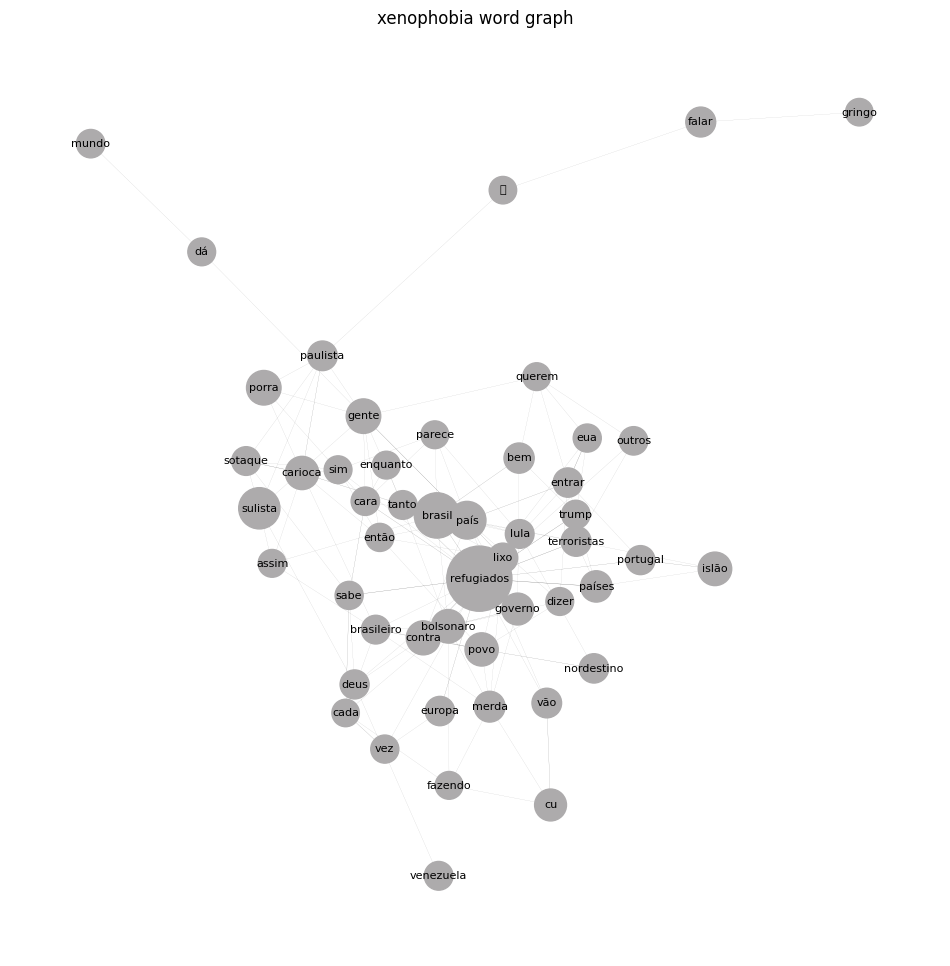

In [9]:
generate_word_graph("xenophobia", "tupi_hierarchy.csv", exclude_terms,50,"#ADABAC")

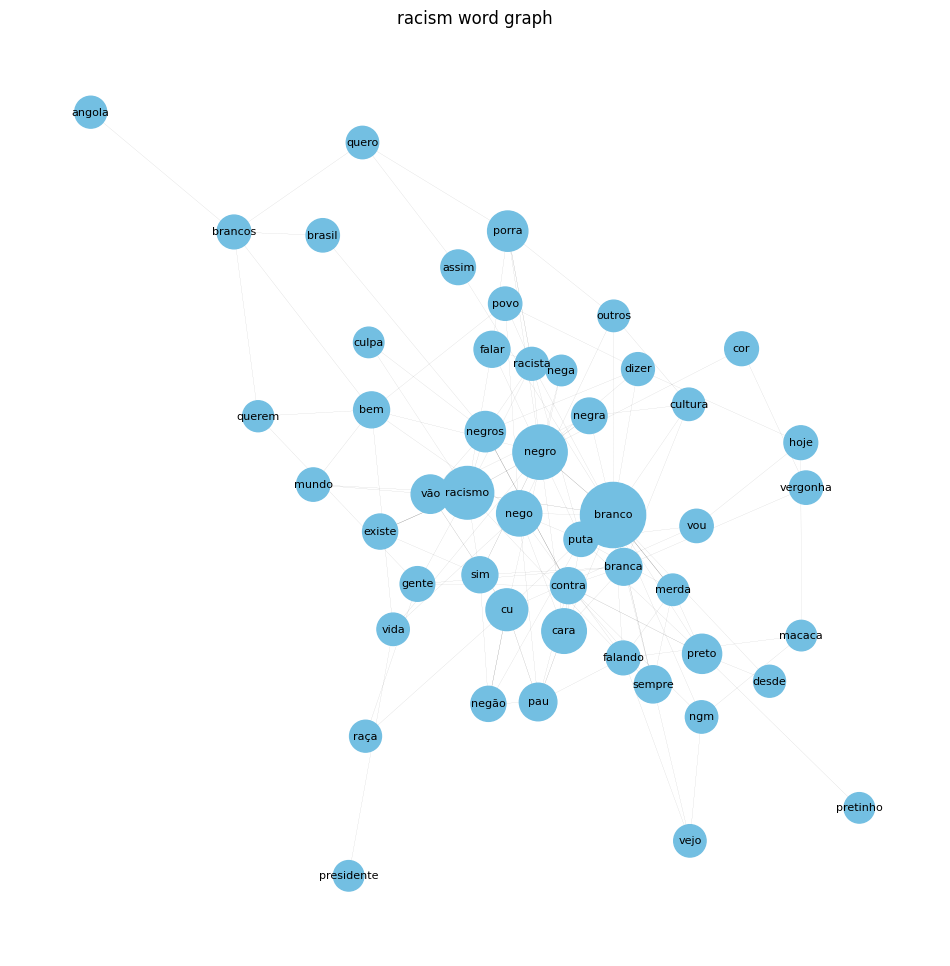

In [10]:
generate_word_graph("racism", "tupi_hierarchy.csv", exclude_terms,50,"#73BFE2")